We will be researching the Cart-pole problem with a policy gradient agorithim

We Must first build our enviorment that are reinforcement learning model will learn in

In [1]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt

Now let's create the neccesary functions for our enviorment

Our model will take in 4 values: X value, X velocity, Theta value, Theta velocity.

We will need the enviorment randomized every new episode played by the model

In [2]:
import random as rand
import math
def Intial_state():
    theta = rand.uniform(-math.radians(6), math.radians(6))
    xpos = rand.uniform(-0.05, 0.05)
    xdot = rand.uniform(-0.5, 0.5)
    theta_dot = 0
    return xpos, xdot, theta, theta_dot

Now lets make the neccessary functions for our model. It needs to pushed to the left and to the right. We will use the data.crtl[0] to use the simulated acctuators that are in our model. The data element is all of the data of the cartpole at any moment this includes X Velo, theta Velo, X Pos, Theta Pos

In [3]:
import numpy as np
FORCE_MAG = 1.0

def right(data, force=FORCE_MAG):
    data.ctrl[0] = np.clip(force, -1.0, 1.0)


def left(data, force=FORCE_MAG):
    data.ctrl[0] = np.clip(-force, -1.0, 1.0)

Our model will need to know the state it is in, so we will create a function to get the raw values of the state for the model

In [4]:
def gather_raw_state(data):
    xpos = data.qpos[0]
    xdot = data.qvel[0]
    theta = data.qpos[1]
    theta_dot = data.qvel[1]
    return np.array([xpos, xdot, theta, theta_dot], dtype=np.float32)

We also need a function to normalize the state to make it easeier for the model to make outputs

In [5]:
def normalize_state(raw_state):
    x, x_dot, theta, theta_dot = raw_state
    sin_theta = math.sin(theta)
    cos_theta = math.cos(theta)
    norm_x = np.clip(x / 1.0, -1.0, 1.0)
    norm_x_dot = np.tanh(x_dot)
    norm_theta_dot = np.tanh(theta_dot)
    return np.array([norm_x, norm_x_dot, sin_theta, cos_theta, norm_theta_dot], dtype=np.float32)

Now we will create the reward funcition for the model

In [6]:
#Limits to determine if the episode is done
THETA_LIMIT_RADIANS = math.radians(12)
X_LIMIT = 1.0

In [ ]:
def compute_reward(raw_state):
    x, x_dot, theta, theta_dot = raw_state
    angle_error = abs(theta)

    position_error = abs(x)
    reward = 1.0
    reward -= 2.0 * (angle_error / THETA_LIMIT_RADIANS)
    reward -= 0.5 * (position_error / X_LIMIT)
    reward -= 0.01 * (abs(x_dot) + abs(theta_dot))
    return max(reward, -2.0)


Now we will make a function to check if an episode is done

In [8]:
def episode_finished(raw_state):
    x, _, theta, _ = raw_state
    return abs(theta) > THETA_LIMIT_RADIANS or abs(x) > X_LIMIT

Now we must create our Nueral Network for the cartpole problem
We will be creating a nueral netowrk through pytorch. It will take in 4 dimensions as an input for the network: X Value, X Velocity, Theta value, Theta Velocity

We will have 3 layers in the netowrk, the first will take in the state layer, second being an input from the frist, and the thrid being an input from the second and outputting an action from our action set. Our action set is either sliding to the left or sliding to the right.

In [9]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self,state_dim = 5, action_dim = 2, hidden_dim = 128):
        super().__init__()
        self.layer1 = nn.Linear(state_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.output_layer(x)  # logits (unnormalized)


We will also make a sample action function for the nueral network

In [10]:
def sample_action(policy_net, state):
    state_t = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
    logits = policy_net(state_t)  # shape [1, action_dim]
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()  # shape [1]
    log_prob = dist.log_prob(action)  # shape [1]
    return action.item(), log_prob.squeeze(0)


In [11]:
def compute_discounted_returns(rewards, gamma=0.99):
    discounted_returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_returns.insert(0, R)
    discounted_returns = torch.FloatTensor(discounted_returns)
    discounted_returns = (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-8)
    return discounted_returns

Code to visualize total reward over time

In [12]:
def plot_rewards(total_rewards_over_time):
    plt.plot(total_rewards_over_time)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward Over Time')
    plt.savefig('total_rewards_over_time_plot.png')

Now lets add our necessary constants for training

In [13]:
RENDER_TRAINING = False
MODEL_PATH = 'cartpole.xml'
EPISODES = 300
MAX_STEPS = 1000


Lets setup the enviorment for the cartpole problem

In [14]:
model = mujoco.MjModel.from_xml_path(MODEL_PATH)
data = mujoco.MjData(model)
if RENDER_TRAINING:
    viewer = mujoco_viewer.MujocoViewer(model, data)
else:
    viewer = None

Setting up model and optimizers for this

In [15]:
policy_net = PolicyNetwork()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.001)

Now lets Make the training loop for policy gradient

Episode 1/300, Total Reward: 7.915, Steps: 42
Episode 2/300, Total Reward: 8.439, Steps: 112
Episode 2/300, Total Reward: 8.439, Steps: 112
Episode 3/300, Total Reward: 21.600, Steps: 49
Episode 3/300, Total Reward: 21.600, Steps: 49
Episode 4/300, Total Reward: 16.533, Steps: 74
Episode 4/300, Total Reward: 16.533, Steps: 74
Episode 5/300, Total Reward: 23.169, Steps: 63
Episode 5/300, Total Reward: 23.169, Steps: 63
Episode 6/300, Total Reward: 19.964, Steps: 62
Episode 6/300, Total Reward: 19.964, Steps: 62
Episode 7/300, Total Reward: -5.249, Steps: 47
Episode 7/300, Total Reward: -5.249, Steps: 47
Episode 8/300, Total Reward: -51.445, Steps: 130
Episode 8/300, Total Reward: -51.445, Steps: 130
Episode 9/300, Total Reward: -7.973, Steps: 26
Episode 9/300, Total Reward: -7.973, Steps: 26
Episode 10/300, Total Reward: -2.035, Steps: 24
Episode 10/300, Total Reward: -2.035, Steps: 24
Episode 11/300, Total Reward: 12.328, Steps: 79
Episode 11/300, Total Reward: 12.328, Steps: 79
Episod

KeyboardInterrupt: 

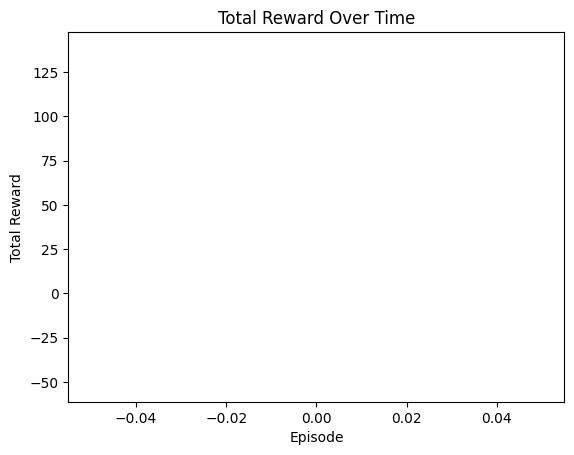

In [17]:
for i in range(EPISODES):
    #initialize the environment for each episode to have a random state
    data.qpos[0], data.qvel[0], data.qpos[1], data.qvel[1] = Intial_state()
    data.ctrl[:] = 0
    #Total reward is used to graph
    total_reward = 0.0
    total_rewards_overtime = []
    rewards = []

    #Lists to store states, actions, and log probabilities for each step
    log_probs = []

    #Getting states
    raw_state = gather_raw_state(data)
    state = normalize_state(raw_state)

    #Now lets iterate through the steps of the episode
    for step in range(MAX_STEPS):

        if RENDER_TRAINING:
            viewer.render()
        
        #Getting the action from the policy network
        action, log_prob = sample_action(policy_net, state)
        #Storing the log probability of the action for training later
        log_probs.append(log_prob)
        if action == 0:
            left(data)
        else:
            right(data)

        #Step the simulation forward
        mujoco.mj_step(model, data)
        next_raw_state = gather_raw_state(data)
        next_state = normalize_state(next_raw_state)

        #Compute the reward and check if the episode is done
        reward = compute_reward(next_raw_state)
        if episode_finished(next_raw_state):
            rewards.append(reward)
            total_reward += reward
            break

        #setting the state to the next state
        state = next_state
        raw_state = next_raw_state
        
        #Accumulate the rewards
        total_reward += reward
        rewards.append(reward)
    
    returns = compute_discounted_returns(rewards, gamma=0.99)
    # Stack log_probs into a tensor and multiply by returns elementwise
    log_probs_t = torch.stack(log_probs)  # shape [T]
    # Ensure lengths match
    T = min(len(returns), len(log_probs_t))
    loss = -(log_probs_t[:T] * returns[:T]).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_rewards_overtime.append(total_reward)
    plot_rewards(total_rewards_overtime)

    
    print(f"Episode {i+1}/{EPISODES}, Total Reward: {float(total_reward):.3f}, Steps: {step+1}")
